# Wafers scratch detection 
## The topic of this notebook is the detection of scratches on wafers.
It is a proposed solution for an assignment published by National Instruments: [NI Scratch detection assignment](https://github.com/NI-DS/scratch_detection_assignment)
<br><br>
While the resulting F1 score may not be optimal, the notebook contains well-designed tabular features created through image processing techniques.<br>
Additionally, the notebook demonstrates how to fine-tune a LightGBM algorithm with an extremely imbalanced dataset, and concludes by implementing an ensemble of LightGBM models to avoid overfitting.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import cohen_kappa_score, f1_score,roc_auc_score, precision_recall_curve, auc,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import zipfile
import pickle
import random
from scipy.signal import convolve2d
from scipy import ndimage
from skimage.feature import canny
from skimage import morphology
from skimage.morphology import skeletonize
from pyod.models.knn import KNN
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
import optuna
from tqdm.notebook import tqdm
tqdm.pandas()
def highlight_cells(val):
    color = 'red' if val > 0 else 'white'
    return f'background-color: {color}'


# Load Data

In [2]:
#load zip file
zf = zipfile.ZipFile('data.zip') 
#load train data
df_wafers = pd.read_csv(zf.open('df_wafers.csv'),dtype = {'IsGoodDie':int,'IsScratchDie':int,'WaferName':str})
display(df_wafers.head())
#load test data
df_wafers_test = pd.read_csv(zf.open('df_wafers_test.csv'),dtype={'WaferName':str,'IsGoodDie':int})
display(df_wafers_test.head())

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,3b2e28,0,12,0,0
1,3b2e28,0,13,1,0
2,3b2e28,0,14,0,0
3,3b2e28,0,15,1,0
4,3b2e28,0,16,1,0


,WaferName,DieX,DieY,IsGoodDie
0,5a6ad6,0,12,0
1,5a6ad6,0,13,1
2,5a6ad6,0,14,1
3,5a6ad6,0,15,1
4,5a6ad6,0,16,1


# **E**xploratory **D**ata **A**nalysis

By quick eye 'test' it seems that indeed the train and test came from the same distribution.<br> also possible to run t-test to prove that...

In [3]:
train_split = round(df_wafers['WaferName'].unique().shape[0]/ \
(df_wafers['WaferName'].unique().shape[0] +\
 df_wafers_test['WaferName'].unique().shape[0]),1)*100
test_split = round(df_wafers_test['WaferName'].unique().shape[0]/ \
(df_wafers['WaferName'].unique().shape[0] +\
 df_wafers_test['WaferName'].unique().shape[0]),1)*100

In [4]:
display(df_wafers.isna().sum())
display(df_wafers_test.isna().sum())

WaferName       0
DieX            0
DieY            0
IsGoodDie       0
IsScratchDie    0
dtype: int64

WaferName    0
DieX         0
DieY         0
IsGoodDie    0
dtype: int64

In [5]:
with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
  display(df_wafers.describe())
  display(df_wafers_test.describe())
  print(f"\n\nNumber of wafers in train: {df_wafers['WaferName'].unique().shape[0]}")
  print(f"Number of wafers in test: {df_wafers_test['WaferName'].unique().shape[0]}")
  print(f"{int(train_split)} - {int(test_split)} split on wafers")
  print(f"The rate of wafers with scratches on: {(df_wafers.groupby('WaferName')['IsScratchDie'].sum() > 0).sum() / len(df_wafers['WaferName'].unique())}")

,DieX,DieY,IsGoodDie,IsScratchDie
count,"16,772,092.000","16,772,092.000","16,772,092.000","16,772,092.000"
mean,41.366,41.366,0.894,0.005
std,23.739,23.739,0.307,0.068
min,0.000,0.000,0.000,0.000
25%,22.000,22.000,1.000,0.000
50%,39.000,39.000,1.000,0.000
75%,59.000,59.000,1.000,0.000
max,104.000,104.000,1.000,1.000


,DieX,DieY,IsGoodDie
count,"1,860,063.000","1,860,063.000","1,860,063.000"
mean,40.900,40.900,0.898
std,23.486,23.486,0.303
min,0.000,0.000,0.000
25%,22.000,22.000,1.000
50%,39.000,39.000,1.000
75%,58.000,58.000,1.000
max,104.000,104.000,1.000




Number of wafers in train: 3920
Number of wafers in test: 439
90 - 10 split on wafers
The rate of wafers with scratches on: 0.4913265306122449


So, from wafers count perspective, it seems that the wafers equally distributed with scartches and without on a fair trade of 50-50...

**Nevertheless** , this is without attending the yield factor, which might cause a drop of samples from the prediction as if the yield is lower than a thershold, there is no point in predicting...<br>
Furthermore, the wafer images are transformed into tabular data which unbalance the prediction column gravely.

Lets try to decide on yield factor, and maybe exclude those wafers which are not supposed to be touched

In [6]:
yield_df = df_wafers.groupby('WaferName')['IsGoodDie'].mean().to_frame()
yield_df['scratch_checked'] = df_wafers.groupby('WaferName')['IsScratchDie'].sum() > 0
yield_df

,IsGoodDie,scratch_checked
WaferName,,
001f23,0.912438,False
002e68,0.783924,False
002ff9,0.893674,False
003483,0.817694,False
004531,0.748843,False
...,...,...
ffa518,0.937268,True
ffdb12,0.839664,False
ffe0d2,0.910773,False


In [7]:
print(f"The Threshold for Scratch-Detection will be greater than {round(yield_df.query('scratch_checked == True')['IsGoodDie'].min(),2)}")

The Threshold for Scratch-Detection will be greater than 0.82


Meaning if the yield ratio is bigger than 82% we will check for scartches. otherwise we will return 0.<br>
Now lets exclude those wafers which below that threshold. while predicting - their label will be assigned automatically as 0.<br> I probably could try to let the model learn this latent factor by itself but its always better practice to apply domain knowledge and rules on data, before predicting. will save training/ inference time, which when on cloud (and not on-premise) can save money.

Now lets exclude from training wafers with yield less than 82%

In [8]:
wafers_zero = yield_df[yield_df['IsGoodDie'] < 0.82].index.tolist()
wafers_train = df_wafers[~df_wafers['WaferName'].isin(wafers_zero)].reset_index(drop=True)
print(f"{len(wafers_zero)} wafers excluded")

527 wafers excluded


In [9]:
print(f"There are {wafers_train['WaferName'].unique().shape[0]} wafers in training set now")

There are 3393 wafers in training set now


Lets see the distribution of labels on the new training data

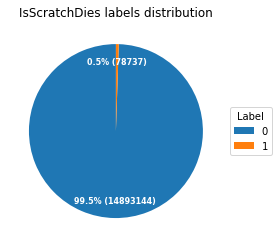

In [10]:
counts = wafers_train['IsScratchDie'].value_counts()

# Calculate the percentages
percentages = counts / counts.sum() * 100

def custom_autopct(pct):
    total = counts.sum()
    val = int(round(pct * total / 100.0))
    return '{:.1f}% ({:d})'.format(pct, val)

# Create the pie chart
fig, ax = plt.subplots()
wedges, text, autotexts = ax.pie(counts, startangle=90, autopct=custom_autopct, pctdistance=0.8,textprops=dict(color="w"))

# Add the labels with both percentage and number
labels = ['{0}'.format(i) for i in counts.index]
legend = ax.legend(wedges, labels, title="Label", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Set the title and display the chart
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("IsScratchDies labels distribution")
plt.show() 

Super unbalanced... Great.

## F1 - Choosing a proper metric for unbalanced data prediction

F1 score is a suitable metric for evaluating imbalanced classification problems because it takes into account both precision and recall.<br>
In the case of highly imbalanced datasets, where the number of negative samples significantly exceeds the number of positive samples, accuracy can be misleading.<br>
F1 score is a harmonic mean of precision and recall, and it considers both false positives and false negatives.<br>
It is a good choice when the goal is to have high precision and recall, which is often the case in detecting rare events or anomalies.

# Building the Prediction mechanism

In [3]:
def drop_low_yield(df,t = 0.82):
    '''
    Drops wafers with yield rate lower than a threshold.
    returns relevant wafers dataframe and the list of not relevant wafers
    '''
    ydf = df.groupby('WaferName')['IsGoodDie'].mean().to_frame()
    wafers_zero = ydf[ydf['IsGoodDie'] < t].index.tolist()
    wafers_new = df[~df['WaferName'].isin(wafers_zero)].reset_index(drop=True)
    return wafers_new,wafers_zero

Drop the wafers from data with yield rate lower than a threshold.<br> Their prediction will be 0/False.

In [4]:
wafers_train , wafers_zero  = drop_low_yield(df_wafers)
wafers_test,test_zero = drop_low_yield(df_wafers_test)

## Now lets create some new features to help catch the scratch:

- **x_diff , y_diff**: the difference between the current row and the previous row for each group. this feature helps capture the changes in coordinates for each wafer separately.

- **faulty_neighbours_3x3, faulty_neighbours_5x5, faulty_neighbours_7x7**: These features represent the number of faulty neighbors in a 3x3, 5x5, and 7x7 square around each point on the wafer, respectively.

- **canny_feature:** This feature represents the presence of edges in the wafer using the Canny edge detection algorithm.

- **bounding_circle_faulty**: This feature represents the presence of faulty dies inside the bounding circle of the wafer.

- **aggressive_out_remv**: This feature represents the removal of any outliers or noisy points from the wafer n times. the survivors of this process are candidates to be on the scratch

- **sobel_median_filter**: This feature represents the application of a Sobel filter and a median filter to the wafer to detect edges and remove noise.

- **connected**: This feature represents the number of connected regions in the wafer.

- **skeleton**: This feature represents the skeleton of the wafer wafer, which is the set of its connected topological lines.

- **skeleton_conv**: This feature represents the skeleton of the wafer after applying convolutional filters.

- **hough_line**: This feature represents the detection of straight lines in the wafer using the Hough transform.

- **median_circle_outliers**: This feature represents the faulty dies in the wafer that survive median filter and are not on the circular boundry of the wafer
---
*I tried to apply only vectorized code with numpy and pandas and used loops only when it was crucial.*
---

In [5]:
wafers_train['x_diff'] = wafers_train.groupby('WaferName')['DieX'].diff()
wafers_train['y_diff'] = wafers_train.groupby('WaferName')['DieY'].diff()
wafers_train.fillna(0, inplace=True)

In [6]:
wafers_train['faulty_feature'] = wafers_train['IsGoodDie'].map({0:1,1:0})

In [7]:
def create_kernels(size):
    """
    Creates two kernels to be used in morphological operations for object detection.

    Args:
    size (int): Size of the kernel (should be odd).

    Returns:
    tuple: A tuple containing two numpy arrays representing the diagonal and non-diagonal kernels.
    """
    diag_kernel = np.zeros((size, size), dtype=int)
    np.fill_diagonal(diag_kernel, 1)
    np.fill_diagonal(diag_kernel[:, ::-1], 1)
    diag_kernel[size // 2, size // 2] = 0

    non_diag_kernel = np.zeros((size, size), dtype=int)
    non_diag_kernel[size // 2, :] = 1
    non_diag_kernel[:, size // 2] = 1
    non_diag_kernel[size // 2, size // 2] = 0

    return diag_kernel, non_diag_kernel

def get_vectorized_info(waf_df,data,column_name):
    """
    Transforms a 2D numpy array into a pandas DataFrame and merges it with an input DataFrame. The output is a
    version of the input data in shape of pandas DataFrame. the process is vectorized without Python for loops

    Args:
    waf_df (pandas.DataFrame): The input DataFrame.
    data (numpy.ndarray): The 2D numpy array to be transformed.
    column_name (str): The name of the column to be created in the output DataFrame.

    Returns:
    pandas.Series: The transofrmed data in vectorized manner.
    """
    rows, cols = data.shape
    data_flattened = data.ravel()
    # Create DieX and DieY coordinates
    DieX, DieY = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    DieX = DieX.ravel()
    DieY = DieY.ravel()

    # Create DataFrame and return the output of transformation
    df_local = pd.DataFrame({'DieX': DieX, 'DieY': DieY, column_name: data_flattened})
    df_local['WaferName'] = waf_df['WaferName'].iloc[0]
    final = waf_df.merge(df_local,how='left')[f'{column_name}']
    final.index = tmpdf.index
    return final

def get_bounding_circle_pixels(disc_array, tolerance = 0.5,outlier= False):
    """
    Given a binary array, finds the bounding circle and returns a binary array where the circle boundary pixels are set to
    1 and the pixels outside the circle are set to 0. Alternatively, if the 'outlier' argument is set to True, the
    function will treat the boundary pixels as outliers and return a binary image where the circle boundary pixels are set
    to 0 and the pixels inside the circle are set to 1.

    Args:
    disc_array (numpy.ndarray): The input binary image.
    tolerance (float): A tolerance value used to determine the thickness of the circle boundary.
    outlier (bool): If True, the circle boundary pixels will be treated as outliers.

    Returns:
    numpy.ndarray: A binary image representing the bounding circle.
    """
    # Find the coordinates of non-zero elements
    coords = np.column_stack(np.nonzero(disc_array))

    # Calculate the center and radius of the bounding circle
    (x, y), radius = cv2.minEnclosingCircle(coords)
    center = (int(x), int(y))
    radius = int(radius)

    # Create a meshgrid of the same size as your grid_array
    xx, yy = np.meshgrid(np.arange(disc_array.shape[1]), np.arange(disc_array.shape[0]))

    # Calculate the distance from each point to the center of the circle
    distances = np.sqrt((xx - center[0]) ** 2 + (yy - center[1]) ** 2)
    if outlier: # Instead of returning the pixels on the circle boundry, treat the boundry as outlier and remove it
        inside_circle_mask = (distances < radius)
        bounding_circle_grid = disc_array.copy()
        bounding_circle_grid[~inside_circle_mask] = 0
        return bounding_circle_grid 

    # Set the value of each point on the boundary of the circle to 1 and outside to 0
    bounding_circle_grid = ((distances <= radius + tolerance) & (distances >= radius - tolerance)).astype(np.uint8)
    return bounding_circle_grid

def remove_outliers(df,method, n = 1):
    """
    Detects and removes outliers from a pandas DataFrame using the specified outlier detection method.

    Args:
    df (pandas.DataFrame): The input DataFrame.
    method (str): The name of the outlier detection method to use (must be 'KNN', 'ISOLATE', or 'ECOD').
    n (int): The number of times to apply the outlier detection method.

    Returns:
    numpy.ndarray: 2d Array witout the outliers.
    """
    ODdata = df.copy()
    if method == 'KNN':
        detector = KNN(n_neighbors = 3)
    elif method == 'ISOLATE':
        detector = IForest()
    else: 
        detector = ECOD()
    for i in range(n):
        if len(ODdata) > 0:
            detector.fit(ODdata)
            y_pred_od = detector.predict(ODdata)
            ODdata = ODdata[y_pred_od == 0]
    return ODdata.reindex_like(df).fillna(0).astype(np.int8).values

def detect_curves_connected_components(disc_array,t=3):
    """
    Given a binary array, returns a binary array containing the connected components (blobs) that meet the specified
    criteria.

    Args:
    disc_array (numpy.ndarray): The input binary array.
    t (int): The minimum area required for a connected component to be included in the output.

    Returns:
    numpy.ndarray: A binary array containing the selected connected components.
    """
    img = np.uint8(disc_array) * 255
    
    # Find connected components
    num_labels, labels = cv2.connectedComponents(img)
    
    output = np.zeros_like(disc_array, dtype=np.uint8)

    for i in range(1, num_labels):
        component = (labels == i).astype(np.uint8)
        area = cv2.countNonZero(component)
        if area > t:
            output = np.logical_or(output, component)

    return output.astype(np.uint8)
def detect_curves_skeletonization(disc_array,t = 0.2):
    """
    Given a binary array, returns a binary array containing the skeleton of the curves.

    Args:
    disc_array (numpy.ndarray): The input binary image.
    t (float): The threshold used to binarize the skeleton array.

    Returns:
    numpy.ndarray: A binary array containing the skeleton of the curves.
    """
    skeleton = morphology.skeletonize(disc_array)
    output = (skeleton > t).astype(np.uint8)
    return output
def apply_Hough_Transform(disc_array,t = 11): # applied on a disc_array after median filter
    """
    Applies Vectorized-ish Hough Transform to an array to detect straight lines.

    Args:
    disc_array (numpy.ndarray): The input binary array.
    t (int): The minimum number of intersections to detect a line.

    Returns:
    numpy.ndarray: A binary array containing the detected lines.
    """
    img = np.uint8(disc_array) * 255
    edges = cv2.Canny(img, 100, 200)
    lines = cv2.HoughLines(edges, 1, np.pi/180, t)
    
    output = np.zeros_like(disc_array, dtype=np.uint8)
    line_image = np.zeros_like(disc_array, dtype=np.uint8)
    
    # Restore the array
    if lines is not None:
        linedf = pd.DataFrame(lines[:,0], columns=['rho', 'theta'])

        # Calculate x and y coordinates for each line using the image dimensions
        height, width = disc_array.shape
        linedf['a'] = np.cos(linedf['theta'])
        linedf['b'] = np.sin(linedf['theta'])
        linedf['x0'] = linedf['a'] * linedf['rho']
        linedf['y0'] = linedf['b'] * linedf['rho']
        linedf['x1'] = (linedf['x0'] + width * (-linedf['b'])).astype(int)
        linedf['y1'] = (linedf['y0'] + height * (linedf['a'])).astype(int)
        linedf['x2'] = (linedf['x0'] - width * (-linedf['b'])).astype(int)
        linedf['y2'] = (linedf['y0'] - height * (linedf['a'])).astype(int)

        # Create line_image and output
        _ = linedf.apply(lambda row: cv2.line(line_image, (int(row['x1']), int(row['y1'])), (int(row['x2']), int(row['y2'])), 1, 2), axis=1)
        output = np.logical_or(output, line_image).astype(np.uint8)
    return output

def detect_curves_skeletonization_conv(disc_array):
    """
    Given a binary array, returns a binary array containing the endpoints of the curves, using convolution.

    Args:
    disc_array (numpy.ndarray): The input binary array.

    Returns:
    numpy.ndarray: A binary array containing the endpoints of the curves.
    """
    skeleton = skeletonize(disc_array).astype(np.uint8)
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    neighbor_count = cv2.filter2D(skeleton, -1, kernel)
    # Find endpoints (pixels with exactly one neighbor)
    endpoints = (skeleton == 1) & (neighbor_count == 2)
    output = np.zeros_like(skeleton)
    output[endpoints] = 1

    return output
#########################################################################################



# Initialization
sizes = [3,5,7]
kernels = {size: create_kernels(size) for size in sizes}

kernel_3x3 = np.ones((3, 3))
kernel_3x3[1, 1] = 0

kernel_5x5 = np.ones((5, 5))
kernel_5x5[2, 2] = 0

kernel_7x7 = np.ones((7, 7))
kernel_7x7[3, 3] = 0

wafers_train['faulty_neighbours_3x3'] = 0
wafers_train['faulty_neighbours_5x5'] = 0
wafers_train['faulty_neighbours_7x7'] = 0
wafers_train['canny_feature'] = 0
wafers_train['bounding_circle_faulty'] = 0
wafers_train['aggresive_out_remv'] = 0
wafers_train['sobol_median_filter'] = 0
wafers_train['connected'] = 0
wafers_train['skeleton'] = 0
wafers_train['skeleton_conv'] = 0
wafers_train['hough_line'] = 0
wafers_train['median_circle_outliers'] = 0




for size in sizes:
    wafers_train[f'faulty_diag_neighbours_{size}x{size}'] = 0
    wafers_train[f'faulty_non_diag_neighbours_{size}x{size}'] = 0

for WaferName in tqdm(wafers_train['WaferName'].unique()):
    tmpdf = wafers_train[wafers_train['WaferName'] == WaferName]
    full_disc = tmpdf\
        .pivot_table(index='DieX', columns='DieY', values='faulty_feature', fill_value=0)\
        .values 
    disc_array = tmpdf\
        .pivot_table(index='DieX', columns='DieY', values='faulty_feature', fill_value=0)\
        .values
    disc_array = ndimage.median_filter(disc_array, size=2)

    convs_vec = {size: (get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernels[size][0], mode='same'),
                                   f'faulty_diag_neighbours_{size}x{size}'),
                        get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernels[size][1], mode='same'),
                                   f'faulty_non_diag_neighbours_{size}x{size}'))
             for size in sizes}
    

    conv_3x3 = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernel_3x3, mode='same'),
                                   'faulty_neighbours_3x3')
    conv_5x5 = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernel_5x5, mode='same'),
                                   'faulty_neighbours_5x5')
    conv_7x7 = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernel_7x7, mode='same'),
                                   'faulty_neighbours_7x7')
    
    canny_edge_det = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,canny(disc_array,sigma=0.7,use_quantiles=True),
                                   'canny_feature').astype(int)
    
    faulty_circle = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,get_bounding_circle_pixels(disc_array,0.5),
                                   'bounding_circle_faulty')
    agg_outs = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,remove_outliers(pd.DataFrame(get_bounding_circle_pixels(disc_array,
                                                                         tolerance = 1,outlier= True)),n=2,method ='ECOD'),'aggresive_out_remv')

    sobol_med_filt = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,np.hypot(ndimage.sobel(ndimage.median_filter(disc_array, size=2), axis=0, mode='constant'),
                                    ndimage.sobel(ndimage.median_filter(disc_array, size=2), axis=1, mode='constant'))\
                                    .astype(np.int8),
                                   'sobol_median_filter')
    connected = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,detect_curves_connected_components(disc_array),
                                   'connected')
    skeleton = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,detect_curves_skeletonization(disc_array),
                                   'skeleton')
    skeleton_conv = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,detect_curves_skeletonization_conv(full_disc),
                                   'skeleton_conv')

    med_circ_filt = ndimage.median_filter( get_bounding_circle_pixels(full_disc,tolerance = 1,outlier= True), size=2)
    med_circ = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,med_circ_filt,
                                   'median_circle_outliers')
    hue = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,apply_Hough_Transform(med_circ_filt),
                                   'hough_line')
       
    wafers_train.loc[conv_3x3.index, 'faulty_neighbours_3x3'] = conv_3x3
    wafers_train.loc[conv_5x5.index, 'faulty_neighbours_5x5'] = conv_5x5
    wafers_train.loc[conv_7x7.index, 'faulty_neighbours_7x7'] = conv_7x7
    wafers_train.loc[canny_edge_det.index, 'canny_feature'] = canny_edge_det
    wafers_train.loc[faulty_circle.index, 'bounding_circle_faulty'] = faulty_circle
    wafers_train.loc[agg_outs.index, 'aggresive_out_remv'] = agg_outs
    wafers_train.loc[sobol_med_filt.index, 'sobol_median_filter'] = sobol_med_filt
    wafers_train.loc[connected.index, 'connected'] = connected
    wafers_train.loc[skeleton.index, 'skeleton'] = skeleton
    wafers_train.loc[skeleton_conv.index, 'skeleton_conv'] = skeleton_conv
    wafers_train.loc[hue.index, 'hough_line'] = hue
    wafers_train.loc[med_circ.index, 'median_circle_outliers'] = med_circ

    for size in sizes:
        wafers_train.loc[convs_vec[size][0].index, f'faulty_diag_neighbours_{size}x{size}'] = convs_vec[size][0]
        wafers_train.loc[convs_vec[size][1].index, f'faulty_non_diag_neighbours_{size}x{size}'] = convs_vec[size][1]


  0%|          | 0/3393 [00:00<?, ?it/s]

## Pick and train a model
Split the training data into train-val-test by groups

In [8]:
def group_train_test_split(df, target_col, group_col, test_size=0.1):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size,random_state=42)
    train_idx, test_idx = next(splitter.split(df, df[target_col], df[group_col]))
    return df.iloc[train_idx], df.iloc[test_idx]

train_df_all, test_df = group_train_test_split(wafers_train.drop('faulty_feature',axis=1), 'IsScratchDie', 'WaferName')
train_df, val_df = group_train_test_split(train_df_all, 'IsScratchDie', 'WaferName')
# Iam dropping the 'WaferName' feature as it shouldnt be learned. a wafer can be either in train/val/test and doesnt have to be included in all of them thus non learnable.
X_train = train_df.iloc[:,1::].drop('IsScratchDie',axis=1).copy()
y_train = train_df['IsScratchDie']

X_test = test_df.iloc[:,1::].drop('IsScratchDie',axis=1).copy()
y_test = test_df['IsScratchDie']

X_val = val_df.iloc[:,1::].drop('IsScratchDie',axis=1).copy()
y_val = val_df['IsScratchDie']

# LightGBM
LightGBM is a boosting model that is efficient and can handle unbalanced data well. It also does not require a GPU to run, making it a great choice for this task.

In [17]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'random_state':  42,
     'scale_pos_weight': np.sqrt(float(np.sum(train_df['IsScratchDie'] == 0)) / np.sum(train_df['IsScratchDie'] == 1))}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

# Train the classifier
clf = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_val], verbose_eval=100)

C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.415580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[100]	training's binary_logloss: 0.0238589	valid_1's binary_logloss: 0.0233996
[200]	training's binary_logloss: 0.0230666	valid_1's binary_logloss: 0.0226217
[300]	training's binary_logloss: 0.0233487	valid_1's binary_logloss: 0.0228668
[400]	training's binary_logloss: 0.02403	valid_1's binary_logloss: 0.0234921
[500]	training's binary_logloss: 0.0248864	valid_1's binary_logloss: 0.0242855
[600]	training's binary_logloss: 0.025809

# Base prediction




F1-score: 0.45


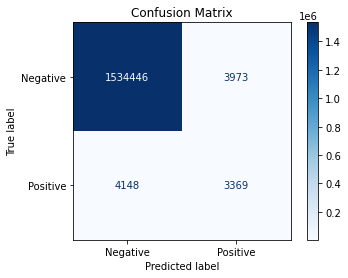

In [18]:
# Make predictions on the test set
y_pred = clf.predict(X_test)


# Compute F1-score
f1 = f1_score(y_test, y_pred.round())
print("\n\n")
print("F1-score: {:.2f}".format(f1))
cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format='.0f')
plt.title("Confusion Matrix")
plt.show()

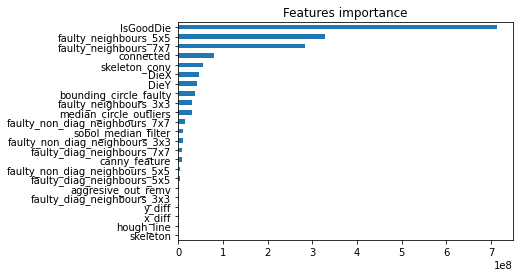

In [19]:
importance = clf.feature_importance(importance_type='gain')
pd.DataFrame(importance,index = X_train.columns).sort_values(by=[0]).plot(kind='barh',title='Features importance',legend=False)
plt.show()

## Picking best features based on feature importance

In [15]:
results = {}
for k in tqdm(np.arange(2,len(importance))):
    top_k_idx = (-importance).argsort()[:k]
    positive_gain = np.where(importance > 0)[0]

    X_train_selected = X_train.iloc[:, top_k_idx]
    X_test_selected = X_test.iloc[:, top_k_idx]

    # Retrain the classifier with the top k features
    lgb_train_selected = lgb.Dataset(X_train_selected, y_train)
    lgb_test_selected = lgb.Dataset(X_test_selected, y_test)

    clf_selected = lgb.train(params, lgb_train_selected, num_boost_round=1000, valid_sets=[lgb_train_selected, lgb_test_selected]
                             , verbose_eval=False)

    y_pred = clf_selected.predict(X_test_selected)
    f1 = f1_score(y_test, y_pred.round())
    results[k] = f1

  0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.211272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.228894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.317744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.362488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 290
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.495939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.551687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.497311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.468162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.611044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.564884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.762953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.624321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.623565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.581665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


Based on the results below, **19 features** perform best.

In [16]:
pd.DataFrame().from_dict(results,orient='index').sort_values(by=0,ascending = False)

,0
19,0.456694
21,0.454472
20,0.453795
18,0.453441
16,0.452853
22,0.452590
17,0.452480
15,0.449903
14,0.447852
13,0.447425


In [35]:
selected_features = X_train.iloc[:, (-importance).argsort()[:19]].columns

In [36]:
selected_features

Index(['IsGoodDie', 'faulty_neighbours_5x5', 'faulty_neighbours_7x7',
       'connected', 'skeleton_conv', 'DieX', 'DieY', 'bounding_circle_faulty',
       'faulty_neighbours_3x3', 'median_circle_outliers',
       'faulty_non_diag_neighbours_7x7', 'sobol_median_filter',
       'faulty_non_diag_neighbours_3x3', 'faulty_diag_neighbours_7x7',
       'canny_feature', 'faulty_non_diag_neighbours_5x5',
       'faulty_diag_neighbours_5x5', 'aggresive_out_remv',
       'faulty_diag_neighbours_3x3'],
      dtype='object')

In [9]:
selected_features = ['IsGoodDie', 'faulty_neighbours_5x5', 'faulty_neighbours_7x7',
       'connected', 'skeleton_conv', 'DieX', 'DieY', 'bounding_circle_faulty',
       'faulty_neighbours_3x3', 'median_circle_outliers',
       'faulty_non_diag_neighbours_7x7', 'sobol_median_filter',
       'faulty_non_diag_neighbours_3x3', 'faulty_diag_neighbours_7x7',
       'canny_feature', 'faulty_non_diag_neighbours_5x5',
       'faulty_diag_neighbours_5x5', 'aggresive_out_remv',
       'faulty_diag_neighbours_3x3']

From doing feature selection based the gain of each feature, i can say that the following features are redundant:
- skeleton
- Hough line (Surprising !)
- x_diff & y_diff features

# Optuna parameters tuning on LightGBM
Now ill tune the parameters and improve the prediction a bit more

In [41]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'pos_bagging_fraction': trial.suggest_uniform('pos_bagging_fraction', 0.1, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'scale_pos_weight': np.sqrt(float(np.sum(train_df['IsScratchDie'] == 0)) / np.sum(train_df['IsScratchDie'] == 1)),
        'verbose':-1
    }

    train_data = lgb.Dataset(X_train[selected_features], label=y_train)
    model = lgb.train(params, train_data, num_boost_round=1000, verbose_eval=False)

    y_pred_proba = model.predict(X_val[selected_features])
    y_pred = np.round(y_pred_proba)

    f1 = f1_score(y_val, y_pred)

    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2023-04-08 13:11:13,435] A new study created in memory with name: no-name-1552ad70-ce98-4852-85da-ace7d865f71c
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.508442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 13:18:00,265] Trial 0 finished with value: 0.39500157183275697 and parameters: {'learning_rate': 0.04664545215001588, 'bagging_fraction': 0.6696977668265672, 'bagging_freq': 2, 'pos_bagging_fraction': 0.9730020822834189, 'feature_fraction': 0.9615739399857871, 'max_depth': 11, 'min_data_in_leaf': 13, 'num_leaves': 22}. Best is trial 0 with value: 0.39500157183275697.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.411710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 13:23:17,997] Trial 1 finished with value: 0.38988518834804065 and parameters: {'learning_rate': 0.020207231133336816, 'bagging_fraction': 0.3182108182697232, 'bagging_freq': 6, 'pos_bagging_fraction': 0.6123005383349559, 'feature_fraction': 0.18839970603313194, 'max_depth': 2, 'min_data_in_leaf': 21, 'num_leaves': 96}. Best is trial 0 with value: 0.39500157183275697.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.433700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 13:31:01,958] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.0003554460793971065, 'bagging_fraction': 0.6308538443534626, 'bagging_freq': 2, 'pos_bagging_fraction': 0.590031957749814, 'feature_fraction': 0.10763471733203313, 'max_depth': 7, 'min_data_in_leaf': 32, 'num_leaves': 84}. Best is trial 0 with value: 0.39500157183275697.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.619393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 13:37:02,384] Trial 3 finished with value: 0.28894987320665577 and parameters: {'learning_rate': 0.12290226921794803, 'bagging_fraction': 0.9307576916762194, 'bagging_freq': 10, 'pos_bagging_fraction': 0.8181561691184374, 'feature_fraction': 0.6711403903171, 'max_depth': 4, 'min_data_in_leaf': 33, 'num_leaves': 76}. Best is trial 0 with value: 0.39500157183275697.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.666713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 13:45:50,860] Trial 4 finished with value: 0.23956259787138043 and parameters: {'learning_rate': 0.12122937475302478, 'bagging_fraction': 0.10888449397293941, 'bagging_freq': 5, 'pos_bagging_fraction': 0.9103003424522701, 'feature_fraction': 0.746171406358502, 'max_depth': 9, 'min_data_in_leaf': 36, 'num_leaves': 98}. Best is trial 0 with value: 0.39500157183275697.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.624406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-08 13:51:09,284] Trial 5 finished with value: 0.04368892798554481 and parameters: {'learning_rate': 0.2750290376704239, 'bagging_fraction': 0.7985963701287416, 'bagging_freq': 10, 'pos_bagging_fraction': 0.6413166706354451, 'feature_fraction': 0.752085748686531, 'max_depth': 3, 'min_data_in_leaf': 34, 'num_leaves': 54}. Best is trial 0 with value: 0.39500157183275697.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.570017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 13:58:32,494] Trial 6 finished with value: 0.45288486416558854 and parameters: {'learning_rate': 0.07332553078916222, 'bagging_fraction': 0.7818211631644406, 'bagging_freq': 9, 'pos_bagging_fraction': 0.5284303338303197, 'feature_fraction': 0.28811099366158543, 'max_depth': 13, 'min_data_in_leaf': 31, 'num_leaves': 23}. Best is trial 6 with value: 0.45288486416558854.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.548320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 14:03:19,578] Trial 7 finished with value: 0.29742802303262955 and parameters: {'learning_rate': 0.0016303692661917965, 'bagging_fraction': 0.876787669728152, 'bagging_freq': 9, 'pos_bagging_fraction': 0.631370257675971, 'feature_fraction': 0.32693781313221926, 'max_depth': 1, 'min_data_in_leaf': 16, 'num_leaves': 79}. Best is trial 6 with value: 0.45288486416558854.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.659608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 14:11:56,912] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 0.00014199316248310443, 'bagging_fraction': 0.336598414195807, 'bagging_freq': 9, 'pos_bagging_fraction': 0.8012698320664043, 'feature_fraction': 0.9836785895290977, 'max_depth': 14, 'min_data_in_leaf': 28, 'num_leaves': 69}. Best is trial 6 with value: 0.45288486416558854.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.564836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 14:18:24,574] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.0005330091807679483, 'bagging_fraction': 0.26636445325062863, 'bagging_freq': 7, 'pos_bagging_fraction': 0.40353279575582424, 'feature_fraction': 0.8001922461629939, 'max_depth': 15, 'min_data_in_leaf': 22, 'num_leaves': 20}. Best is trial 6 with value: 0.45288486416558854.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-08 14:24:29,669] Trial 10 finished with value: 0.047459838538693636 and parameters: {'learning_rate': 0.9691050687927217, 'bagging_fraction': 0.4974981956025999, 'bagging_freq': 4, 'pos_bagging_fraction': 0.14231993148336375, 'feature_fraction': 0.44946636553158015, 'max_depth': 12, 'min_data_in_leaf': 48, 'num_leaves': 41}. Best is trial 6 with value: 0.45288486416558854.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.586097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 14:29:25,817] Trial 11 finished with value: 0.45521240089930187 and parameters: {'learning_rate': 0.017276299506201773, 'bagging_fraction': 0.711891353068513, 'bagging_freq': 1, 'pos_bagging_fraction': 0.37344864491732144, 'feature_fraction': 0.4743189102962223, 'max_depth': 11, 'min_data_in_leaf': 10, 'num_leaves': 10}. Best is trial 11 with value: 0.45521240089930187.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.526744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 14:34:44,363] Trial 12 finished with value: 0.4521547232268743 and parameters: {'learning_rate': 0.006054642700471701, 'bagging_fraction': 0.7537352837519214, 'bagging_freq': 1, 'pos_bagging_fraction': 0.36012603018497313, 'feature_fraction': 0.439575675429405, 'max_depth': 12, 'min_data_in_leaf': 47, 'num_leaves': 12}. Best is trial 11 with value: 0.45521240089930187.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.577009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 14:42:52,803] Trial 13 finished with value: 0.459082591961638 and parameters: {'learning_rate': 0.004481618806402228, 'bagging_fraction': 0.5155324133869701, 'bagging_freq': 7, 'pos_bagging_fraction': 0.3851136173070694, 'feature_fraction': 0.3074493040763334, 'max_depth': 9, 'min_data_in_leaf': 41, 'num_leaves': 35}. Best is trial 13 with value: 0.459082591961638.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.672384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 14:51:14,326] Trial 14 finished with value: 0.46685921647041406 and parameters: {'learning_rate': 0.0035426371587276777, 'bagging_fraction': 0.4808807837268905, 'bagging_freq': 7, 'pos_bagging_fraction': 0.23302677122859683, 'feature_fraction': 0.554896264717585, 'max_depth': 8, 'min_data_in_leaf': 41, 'num_leaves': 41}. Best is trial 14 with value: 0.46685921647041406.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.661059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 14:59:31,591] Trial 15 finished with value: 0.4186863364945557 and parameters: {'learning_rate': 0.004486020737574012, 'bagging_fraction': 0.5136699708707178, 'bagging_freq': 7, 'pos_bagging_fraction': 0.13733393128122443, 'feature_fraction': 0.5968023618104896, 'max_depth': 6, 'min_data_in_leaf': 42, 'num_leaves': 40}. Best is trial 14 with value: 0.46685921647041406.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.616442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 15:07:55,961] Trial 16 finished with value: 0.3754854598844369 and parameters: {'learning_rate': 0.0018151693285566796, 'bagging_fraction': 0.46195223161163673, 'bagging_freq': 7, 'pos_bagging_fraction': 0.25846348176956957, 'feature_fraction': 0.32211321802580517, 'max_depth': 9, 'min_data_in_leaf': 41, 'num_leaves': 39}. Best is trial 14 with value: 0.46685921647041406.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.550832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 15:15:55,802] Trial 17 finished with value: 0.41426060758222444 and parameters: {'learning_rate': 0.0020453308279158346, 'bagging_fraction': 0.4125969966095222, 'bagging_freq': 4, 'pos_bagging_fraction': 0.25596354262768817, 'feature_fraction': 0.565192546565097, 'max_depth': 5, 'min_data_in_leaf': 41, 'num_leaves': 55}. Best is trial 14 with value: 0.46685921647041406.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 15:24:18,553] Trial 18 finished with value: 0.0 and parameters: {'learning_rate': 0.0006473686350680145, 'bagging_fraction': 0.5805152567201289, 'bagging_freq': 8, 'pos_bagging_fraction': 0.46589417505987807, 'feature_fraction': 0.24230867218331598, 'max_depth': 8, 'min_data_in_leaf': 50, 'num_leaves': 55}. Best is trial 14 with value: 0.46685921647041406.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.479395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 15:33:32,630] Trial 19 finished with value: 0.47919511318720803 and parameters: {'learning_rate': 0.008964337836117477, 'bagging_fraction': 0.190590148232397, 'bagging_freq': 5, 'pos_bagging_fraction': 0.22385358345566175, 'feature_fraction': 0.398199765492044, 'max_depth': 9, 'min_data_in_leaf': 39, 'num_leaves': 34}. Best is trial 19 with value: 0.47919511318720803.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.691985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 15:42:17,664] Trial 20 finished with value: 0.4799173269032036 and parameters: {'learning_rate': 0.015436243632876467, 'bagging_fraction': 0.106918734952904, 'bagging_freq': 5, 'pos_bagging_fraction': 0.24973706459651182, 'feature_fraction': 0.49290800736909113, 'max_depth': 7, 'min_data_in_leaf': 27, 'num_leaves': 31}. Best is trial 20 with value: 0.4799173269032036.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.623643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 15:50:44,087] Trial 21 finished with value: 0.487986511170437 and parameters: {'learning_rate': 0.016293298047172288, 'bagging_fraction': 0.12521795525567192, 'bagging_freq': 5, 'pos_bagging_fraction': 0.23720130104293644, 'feature_fraction': 0.40107893892068797, 'max_depth': 7, 'min_data_in_leaf': 26, 'num_leaves': 30}. Best is trial 21 with value: 0.487986511170437.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.504406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 15:58:55,421] Trial 22 finished with value: 0.4141349242771914 and parameters: {'learning_rate': 0.019958620277223314, 'bagging_fraction': 0.1166049881009883, 'bagging_freq': 4, 'pos_bagging_fraction': 0.10271441959401684, 'feature_fraction': 0.38718736986362523, 'max_depth': 5, 'min_data_in_leaf': 27, 'num_leaves': 29}. Best is trial 21 with value: 0.487986511170437.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.505849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 16:07:34,729] Trial 23 finished with value: 0.4733754177497215 and parameters: {'learning_rate': 0.009429492054622849, 'bagging_fraction': 0.2027557646753932, 'bagging_freq': 5, 'pos_bagging_fraction': 0.21089789389100555, 'feature_fraction': 0.3812555722270403, 'max_depth': 7, 'min_data_in_leaf': 24, 'num_leaves': 33}. Best is trial 21 with value: 0.487986511170437.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.618858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 16:16:30,335] Trial 24 finished with value: 0.48951409950312963 and parameters: {'learning_rate': 0.03168370491306933, 'bagging_fraction': 0.1967390117841049, 'bagging_freq': 3, 'pos_bagging_fraction': 0.2941647837797235, 'feature_fraction': 0.48912520898395273, 'max_depth': 10, 'min_data_in_leaf': 18, 'num_leaves': 48}. Best is trial 24 with value: 0.48951409950312963.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.619811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 16:26:12,230] Trial 25 finished with value: 0.4713845476557341 and parameters: {'learning_rate': 0.030441713792238465, 'bagging_fraction': 0.19349147314636098, 'bagging_freq': 3, 'pos_bagging_fraction': 0.4663783769765527, 'feature_fraction': 0.5324607125015075, 'max_depth': 10, 'min_data_in_leaf': 19, 'num_leaves': 48}. Best is trial 24 with value: 0.48951409950312963.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.649825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-08 16:33:37,999] Trial 26 finished with value: 0.03586260810084526 and parameters: {'learning_rate': 0.20961710883665477, 'bagging_fraction': 0.2581298674018548, 'bagging_freq': 3, 'pos_bagging_fraction': 0.30129840722234646, 'feature_fraction': 0.6699083353405795, 'max_depth': 6, 'min_data_in_leaf': 25, 'num_leaves': 48}. Best is trial 24 with value: 0.48951409950312963.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.652635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 16:42:51,841] Trial 27 finished with value: 0.48965175362498453 and parameters: {'learning_rate': 0.04790710450766211, 'bagging_fraction': 0.10357296508846847, 'bagging_freq': 6, 'pos_bagging_fraction': 0.33500919121609124, 'feature_fraction': 0.4966376819408897, 'max_depth': 7, 'min_data_in_leaf': 18, 'num_leaves': 63}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.668288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 16:53:12,531] Trial 28 finished with value: 0.36042700627399565 and parameters: {'learning_rate': 0.04238859900975598, 'bagging_fraction': 0.389574340731537, 'bagging_freq': 6, 'pos_bagging_fraction': 0.3204877075377065, 'feature_fraction': 0.6216739999681244, 'max_depth': 10, 'min_data_in_leaf': 17, 'num_leaves': 66}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.567848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 17:02:22,508] Trial 29 finished with value: 0.4051624129930394 and parameters: {'learning_rate': 0.06933641229435414, 'bagging_fraction': 0.16862597254854628, 'bagging_freq': 3, 'pos_bagging_fraction': 0.45843442757110137, 'feature_fraction': 0.8333731521257477, 'max_depth': 11, 'min_data_in_leaf': 13, 'num_leaves': 64}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.511477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 17:11:26,875] Trial 30 finished with value: 0.4811136192626035 and parameters: {'learning_rate': 0.037841097839220135, 'bagging_fraction': 0.26959694950143465, 'bagging_freq': 2, 'pos_bagging_fraction': 0.18934569982018618, 'feature_fraction': 0.5040443497172763, 'max_depth': 5, 'min_data_in_leaf': 14, 'num_leaves': 61}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.665077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 17:20:21,700] Trial 31 finished with value: 0.47445197289756874 and parameters: {'learning_rate': 0.03762665938944049, 'bagging_fraction': 0.25795829306236184, 'bagging_freq': 2, 'pos_bagging_fraction': 0.1572409596851616, 'feature_fraction': 0.5119365115271653, 'max_depth': 5, 'min_data_in_leaf': 13, 'num_leaves': 61}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.474991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 17:27:02,631] Trial 32 finished with value: 0.4679676225136475 and parameters: {'learning_rate': 0.06356414902772624, 'bagging_fraction': 0.291987866247033, 'bagging_freq': 2, 'pos_bagging_fraction': 0.31771444285993944, 'feature_fraction': 0.4196767254544133, 'max_depth': 3, 'min_data_in_leaf': 17, 'num_leaves': 72}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.444848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-08 17:33:12,355] Trial 33 finished with value: 0.2443885043003986 and parameters: {'learning_rate': 0.4134115274482082, 'bagging_fraction': 0.15885500919467713, 'bagging_freq': 6, 'pos_bagging_fraction': 0.18362079383868068, 'feature_fraction': 0.16027063160879929, 'max_depth': 7, 'min_data_in_leaf': 20, 'num_leaves': 91}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.582690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 17:42:24,611] Trial 34 finished with value: 0.48665885721723284 and parameters: {'learning_rate': 0.028925723172474604, 'bagging_fraction': 0.22811214757620984, 'bagging_freq': 3, 'pos_bagging_fraction': 0.2935678549397163, 'feature_fraction': 0.629267050010043, 'max_depth': 6, 'min_data_in_leaf': 10, 'num_leaves': 47}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.557780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 17:50:02,755] Trial 35 finished with value: 0.31030712652817805 and parameters: {'learning_rate': 0.11683959906817136, 'bagging_fraction': 0.3541125250278094, 'bagging_freq': 4, 'pos_bagging_fraction': 0.3018538778647621, 'feature_fraction': 0.6575809344620567, 'max_depth': 8, 'min_data_in_leaf': 10, 'num_leaves': 48}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.694313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 17:57:39,901] Trial 36 finished with value: 0.4411690728909905 and parameters: {'learning_rate': 0.010571842517257842, 'bagging_fraction': 0.21672819703542834, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5465721179965193, 'feature_fraction': 0.8766572758104542, 'max_depth': 6, 'min_data_in_leaf': 22, 'num_leaves': 23}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.619385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 18:03:57,277] Trial 37 finished with value: 0.4123948649845064 and parameters: {'learning_rate': 0.025572438692893596, 'bagging_fraction': 0.13660758211139035, 'bagging_freq': 6, 'pos_bagging_fraction': 0.7276519902606089, 'feature_fraction': 0.716416205350743, 'max_depth': 4, 'min_data_in_leaf': 19, 'num_leaves': 52}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.559507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 18:11:14,233] Trial 38 finished with value: 0.32678674075493397 and parameters: {'learning_rate': 0.1083006649753358, 'bagging_fraction': 0.22673923388518866, 'bagging_freq': 4, 'pos_bagging_fraction': 0.41594597751952, 'feature_fraction': 0.6073927749097321, 'max_depth': 8, 'min_data_in_leaf': 15, 'num_leaves': 46}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.479929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 18:22:02,266] Trial 39 finished with value: 0.4672491395287265 and parameters: {'learning_rate': 0.012906946265991322, 'bagging_fraction': 0.1480313353968273, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5113397547942595, 'feature_fraction': 0.3467023594247854, 'max_depth': 10, 'min_data_in_leaf': 30, 'num_leaves': 81}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.542593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-08 18:28:30,460] Trial 40 finished with value: 0.17893750836344174 and parameters: {'learning_rate': 0.23051905814000334, 'bagging_fraction': 0.32142098606144215, 'bagging_freq': 8, 'pos_bagging_fraction': 0.3393523282830631, 'feature_fraction': 0.26750124247410034, 'max_depth': 3, 'min_data_in_leaf': 11, 'num_leaves': 87}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.698792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 18:37:08,886] Trial 41 finished with value: 0.480365296803653 and parameters: {'learning_rate': 0.05788260317875629, 'bagging_fraction': 0.2371787289501273, 'bagging_freq': 2, 'pos_bagging_fraction': 0.2861243250280153, 'feature_fraction': 0.4973007206393626, 'max_depth': 4, 'min_data_in_leaf': 14, 'num_leaves': 60}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.717567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 18:44:04,839] Trial 42 finished with value: 0.3977686342775756 and parameters: {'learning_rate': 0.028390104825516415, 'bagging_fraction': 0.10274652700975198, 'bagging_freq': 1, 'pos_bagging_fraction': 0.9732927816531871, 'feature_fraction': 0.569989989712113, 'max_depth': 6, 'min_data_in_leaf': 12, 'num_leaves': 73}. Best is trial 27 with value: 0.48965175362498453.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.541100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 18:54:50,196] Trial 43 finished with value: 0.4914167833198261 and parameters: {'learning_rate': 0.04378421470784909, 'bagging_fraction': 0.29082016008759026, 'bagging_freq': 2, 'pos_bagging_fraction': 0.19682386988907874, 'feature_fraction': 0.4645214694373282, 'max_depth': 7, 'min_data_in_leaf': 17, 'num_leaves': 63}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.567449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 19:03:42,494] Trial 44 finished with value: 0.4536370233908335 and parameters: {'learning_rate': 0.09051119484978845, 'bagging_fraction': 0.29872684689950424, 'bagging_freq': 5, 'pos_bagging_fraction': 0.41721303048066705, 'feature_fraction': 0.4563635872759211, 'max_depth': 7, 'min_data_in_leaf': 24, 'num_leaves': 52}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.507871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-08 19:09:56,370] Trial 45 finished with value: 0.1682925519537473 and parameters: {'learning_rate': 0.17372556006786222, 'bagging_fraction': 0.36128533418134945, 'bagging_freq': 1, 'pos_bagging_fraction': 0.10521008615882865, 'feature_fraction': 0.35624765003780823, 'max_depth': 7, 'min_data_in_leaf': 18, 'num_leaves': 19}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.503766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 19:17:44,683] Trial 46 finished with value: 0.47119215445908674 and parameters: {'learning_rate': 0.023729428191909253, 'bagging_fraction': 0.1651617480515874, 'bagging_freq': 3, 'pos_bagging_fraction': 0.1746571606501959, 'feature_fraction': 0.7060297916532801, 'max_depth': 8, 'min_data_in_leaf': 16, 'num_leaves': 27}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.724363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-08 19:24:26,986] Trial 47 finished with value: 0.18008523827973652 and parameters: {'learning_rate': 0.5333987160871306, 'bagging_fraction': 0.6225440162112894, 'bagging_freq': 6, 'pos_bagging_fraction': 0.2684974793806659, 'feature_fraction': 0.43594065094883766, 'max_depth': 6, 'min_data_in_leaf': 21, 'num_leaves': 58}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.535271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 19:35:44,870] Trial 48 finished with value: 0.47953287512925 and parameters: {'learning_rate': 0.007585816076571491, 'bagging_fraction': 0.4177377293634934, 'bagging_freq': 2, 'pos_bagging_fraction': 0.35325120077037997, 'feature_fraction': 0.47199894192211733, 'max_depth': 12, 'min_data_in_leaf': 32, 'num_leaves': 68}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.589364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 19:43:31,697] Trial 49 finished with value: 0.40560922913864095 and parameters: {'learning_rate': 0.045922710718333, 'bagging_fraction': 0.9601721776566401, 'bagging_freq': 4, 'pos_bagging_fraction': 0.9272073904025966, 'feature_fraction': 0.6271405037598505, 'max_depth': 9, 'min_data_in_leaf': 22, 'num_leaves': 37}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.610604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 19:50:23,643] Trial 50 finished with value: 0.2637992359372942 and parameters: {'learning_rate': 0.15242097951153027, 'bagging_fraction': 0.8894792056168814, 'bagging_freq': 5, 'pos_bagging_fraction': 0.6856995664687933, 'feature_fraction': 0.5516771206954367, 'max_depth': 13, 'min_data_in_leaf': 34, 'num_leaves': 44}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.479188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 19:59:05,253] Trial 51 finished with value: 0.47362978283350565 and parameters: {'learning_rate': 0.017813158995901426, 'bagging_fraction': 0.28517743395770856, 'bagging_freq': 2, 'pos_bagging_fraction': 0.20704973542165622, 'feature_fraction': 0.5220545327664755, 'max_depth': 5, 'min_data_in_leaf': 14, 'num_leaves': 58}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.444463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 20:02:54,803] Trial 52 finished with value: 0.4024812696366712 and parameters: {'learning_rate': 0.037270123094510985, 'bagging_fraction': 0.2333923193998667, 'bagging_freq': 1, 'pos_bagging_fraction': 0.1894797185825943, 'feature_fraction': 0.42261783072806025, 'max_depth': 1, 'min_data_in_leaf': 15, 'num_leaves': 64}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.543196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 20:10:33,858] Trial 53 finished with value: 0.45750332005312083 and parameters: {'learning_rate': 0.07479434331757341, 'bagging_fraction': 0.1896626589177126, 'bagging_freq': 2, 'pos_bagging_fraction': 0.1371224671026151, 'feature_fraction': 0.5758913409506835, 'max_depth': 4, 'min_data_in_leaf': 12, 'num_leaves': 71}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.503707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 20:19:12,406] Trial 54 finished with value: 0.4686068635050384 and parameters: {'learning_rate': 0.014250382904728208, 'bagging_fraction': 0.13722729708894166, 'bagging_freq': 3, 'pos_bagging_fraction': 0.2441010507617683, 'feature_fraction': 0.47832322065398103, 'max_depth': 5, 'min_data_in_leaf': 10, 'num_leaves': 77}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.589523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 20:25:18,865] Trial 55 finished with value: 0.45793547090159814 and parameters: {'learning_rate': 0.049772686280536764, 'bagging_fraction': 0.32708859765370124, 'bagging_freq': 1, 'pos_bagging_fraction': 0.586421603383072, 'feature_fraction': 0.5186003783190282, 'max_depth': 7, 'min_data_in_leaf': 17, 'num_leaves': 51}. Best is trial 43 with value: 0.4914167833198261.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.567610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 20:34:44,507] Trial 56 finished with value: 0.49186400317502316 and parameters: {'learning_rate': 0.030723765062932857, 'bagging_fraction': 0.24675677645100905, 'bagging_freq': 2, 'pos_bagging_fraction': 0.27900638768488023, 'feature_fraction': 0.37319574558627155, 'max_depth': 6, 'min_data_in_leaf': 20, 'num_leaves': 62}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.510054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 20:43:04,634] Trial 57 finished with value: 0.4424055512721665 and parameters: {'learning_rate': 0.006269683420149747, 'bagging_fraction': 0.1806556990326032, 'bagging_freq': 4, 'pos_bagging_fraction': 0.2722087025824362, 'feature_fraction': 0.2219044562186795, 'max_depth': 8, 'min_data_in_leaf': 25, 'num_leaves': 56}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.462354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 20:52:02,015] Trial 58 finished with value: 0.4756884809002073 and parameters: {'learning_rate': 0.02128499393901205, 'bagging_fraction': 0.22236732962407446, 'bagging_freq': 3, 'pos_bagging_fraction': 0.38598414505275297, 'feature_fraction': 0.30635743661722153, 'max_depth': 6, 'min_data_in_leaf': 28, 'num_leaves': 66}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.522301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 20:58:44,218] Trial 59 finished with value: 0.4656181419166057 and parameters: {'learning_rate': 0.012579661674056724, 'bagging_fraction': 0.13522311825438996, 'bagging_freq': 8, 'pos_bagging_fraction': 0.34680798101338356, 'feature_fraction': 0.38470012587656477, 'max_depth': 9, 'min_data_in_leaf': 20, 'num_leaves': 15}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.651951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 21:07:42,003] Trial 60 finished with value: 0.4543006494535086 and parameters: {'learning_rate': 0.002957396754873604, 'bagging_fraction': 0.10367249132432305, 'bagging_freq': 3, 'pos_bagging_fraction': 0.22618279258768204, 'feature_fraction': 0.4145845103385819, 'max_depth': 7, 'min_data_in_leaf': 23, 'num_leaves': 43}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.382444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 21:16:24,979] Trial 61 finished with value: 0.48853707714136363 and parameters: {'learning_rate': 0.03208826503007558, 'bagging_fraction': 0.2668833272975992, 'bagging_freq': 2, 'pos_bagging_fraction': 0.1967175072822665, 'feature_fraction': 0.37493501674263907, 'max_depth': 6, 'min_data_in_leaf': 18, 'num_leaves': 60}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.402887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 21:22:42,664] Trial 62 finished with value: 0.4897511924713162 and parameters: {'learning_rate': 0.031956872793676004, 'bagging_fraction': 0.25288579421403257, 'bagging_freq': 1, 'pos_bagging_fraction': 0.3000029364138272, 'feature_fraction': 0.34963247810788395, 'max_depth': 6, 'min_data_in_leaf': 18, 'num_leaves': 75}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.397620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 21:29:25,539] Trial 63 finished with value: 0.45743405275779375 and parameters: {'learning_rate': 0.0847577021638256, 'bagging_fraction': 0.4482781790134106, 'bagging_freq': 1, 'pos_bagging_fraction': 0.14539784694260222, 'feature_fraction': 0.3572491360818048, 'max_depth': 8, 'min_data_in_leaf': 19, 'num_leaves': 75}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.390215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 21:35:31,724] Trial 64 finished with value: 0.4758152173913044 and parameters: {'learning_rate': 0.05423730353114597, 'bagging_fraction': 0.25406350034965774, 'bagging_freq': 1, 'pos_bagging_fraction': 0.2213694197527982, 'feature_fraction': 0.3295957446224793, 'max_depth': 11, 'min_data_in_leaf': 18, 'num_leaves': 63}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.391275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 21:44:33,390] Trial 65 finished with value: 0.4843769927305191 and parameters: {'learning_rate': 0.01849559919525562, 'bagging_fraction': 0.3768537604099239, 'bagging_freq': 2, 'pos_bagging_fraction': 0.31926657956281757, 'feature_fraction': 0.29017313904749364, 'max_depth': 7, 'min_data_in_leaf': 20, 'num_leaves': 69}. Best is trial 56 with value: 0.49186400317502316.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.401324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 21:50:46,255] Trial 66 finished with value: 0.49354531865742635 and parameters: {'learning_rate': 0.03759664544307725, 'bagging_fraction': 0.29477140827438575, 'bagging_freq': 1, 'pos_bagging_fraction': 0.2555546416531933, 'feature_fraction': 0.45423758450729007, 'max_depth': 6, 'min_data_in_leaf': 16, 'num_leaves': 83}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.374135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 21:56:02,551] Trial 67 finished with value: 0.4839799918886035 and parameters: {'learning_rate': 0.03309479798479477, 'bagging_fraction': 0.3062618537048627, 'bagging_freq': 1, 'pos_bagging_fraction': 0.26418335682568783, 'feature_fraction': 0.4515998447824623, 'max_depth': 5, 'min_data_in_leaf': 17, 'num_leaves': 83}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.400614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 22:02:04,742] Trial 68 finished with value: 0.482839542387797 and parameters: {'learning_rate': 0.09160722201937288, 'bagging_fraction': 0.3396791224083061, 'bagging_freq': 1, 'pos_bagging_fraction': 0.3880328881850191, 'feature_fraction': 0.257727057212914, 'max_depth': 6, 'min_data_in_leaf': 15, 'num_leaves': 92}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.437082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 22:09:05,417] Trial 69 finished with value: 0.44111534464842395 and parameters: {'learning_rate': 0.0443229496701118, 'bagging_fraction': 0.27870492931287777, 'bagging_freq': 2, 'pos_bagging_fraction': 0.12271904362040795, 'feature_fraction': 0.3611499955500902, 'max_depth': 4, 'min_data_in_leaf': 16, 'num_leaves': 87}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.400528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 22:16:30,444] Trial 70 finished with value: 0.2696903712358596 and parameters: {'learning_rate': 0.13277832685282637, 'bagging_fraction': 0.19036569932957798, 'bagging_freq': 2, 'pos_bagging_fraction': 0.16323074891232178, 'feature_fraction': 0.20996629102565698, 'max_depth': 5, 'min_data_in_leaf': 21, 'num_leaves': 79}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.402009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 22:22:41,709] Trial 71 finished with value: 0.49141347424042275 and parameters: {'learning_rate': 0.023298755180374976, 'bagging_fraction': 0.2508127282988331, 'bagging_freq': 1, 'pos_bagging_fraction': 0.2436336665356389, 'feature_fraction': 0.400765447189952, 'max_depth': 6, 'min_data_in_leaf': 18, 'num_leaves': 58}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.405952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 22:28:49,257] Trial 72 finished with value: 0.4869233029679694 and parameters: {'learning_rate': 0.022508775910114562, 'bagging_fraction': 0.2544104260716907, 'bagging_freq': 1, 'pos_bagging_fraction': 0.20853376096591358, 'feature_fraction': 0.3972821907351676, 'max_depth': 6, 'min_data_in_leaf': 18, 'num_leaves': 59}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 22:34:52,635] Trial 73 finished with value: 0.4929182084981498 and parameters: {'learning_rate': 0.0624608279124987, 'bagging_fraction': 0.20560404694936657, 'bagging_freq': 1, 'pos_bagging_fraction': 0.30614262578385026, 'feature_fraction': 0.4847755996651121, 'max_depth': 6, 'min_data_in_leaf': 19, 'num_leaves': 54}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.619945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-08 22:41:23,351] Trial 74 finished with value: 0.27438706311945754 and parameters: {'learning_rate': 0.06209400805329046, 'bagging_fraction': 0.1664269059231762, 'bagging_freq': 1, 'pos_bagging_fraction': 0.3173902336823011, 'feature_fraction': 0.4663384245379258, 'max_depth': 7, 'min_data_in_leaf': 23, 'num_leaves': 50}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.414004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 22:46:47,432] Trial 75 finished with value: 0.47149184279867695 and parameters: {'learning_rate': 0.050023329696631084, 'bagging_fraction': 0.21350318023466483, 'bagging_freq': 1, 'pos_bagging_fraction': 0.43598837863078677, 'feature_fraction': 0.43732829972433096, 'max_depth': 5, 'min_data_in_leaf': 21, 'num_leaves': 55}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.462608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 22:53:50,800] Trial 76 finished with value: 0.4892095769104624 and parameters: {'learning_rate': 0.011256429007551232, 'bagging_fraction': 0.2049453126671293, 'bagging_freq': 1, 'pos_bagging_fraction': 0.28625563928565056, 'feature_fraction': 0.47592259898925876, 'max_depth': 8, 'min_data_in_leaf': 16, 'num_leaves': 63}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.519497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-08 23:04:16,326] Trial 77 finished with value: 0.0 and parameters: {'learning_rate': 0.0002309324537922082, 'bagging_fraction': 0.3068910965542077, 'bagging_freq': 2, 'pos_bagging_fraction': 0.36745757254575306, 'feature_fraction': 0.5280282293761371, 'max_depth': 15, 'min_data_in_leaf': 19, 'num_leaves': 67}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.453804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 23:11:13,320] Trial 78 finished with value: 0.48857620507105043 and parameters: {'learning_rate': 0.02594079141559528, 'bagging_fraction': 0.40750604518850797, 'bagging_freq': 1, 'pos_bagging_fraction': 0.24137417054987942, 'feature_fraction': 0.4973365666579799, 'max_depth': 6, 'min_data_in_leaf': 12, 'num_leaves': 53}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.508717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 23:21:42,047] Trial 79 finished with value: 0.23527773910622307 and parameters: {'learning_rate': 0.10414789188477792, 'bagging_fraction': 0.24569651816722957, 'bagging_freq': 2, 'pos_bagging_fraction': 0.32514746744159173, 'feature_fraction': 0.5935579219067432, 'max_depth': 9, 'min_data_in_leaf': 16, 'num_leaves': 56}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.500062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 23:29:22,681] Trial 80 finished with value: 0.49140871355943105 and parameters: {'learning_rate': 0.06893522620135475, 'bagging_fraction': 0.7003278492940994, 'bagging_freq': 1, 'pos_bagging_fraction': 0.2873828369101886, 'feature_fraction': 0.40751594688787823, 'max_depth': 7, 'min_data_in_leaf': 14, 'num_leaves': 70}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.518987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 23:37:04,597] Trial 81 finished with value: 0.4925373134328358 and parameters: {'learning_rate': 0.06863397447684504, 'bagging_fraction': 0.8092254276964223, 'bagging_freq': 1, 'pos_bagging_fraction': 0.2884309126174049, 'feature_fraction': 0.41101188484683987, 'max_depth': 7, 'min_data_in_leaf': 20, 'num_leaves': 70}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.529514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 23:44:38,051] Trial 82 finished with value: 0.20649924492421276 and parameters: {'learning_rate': 0.07796879484900546, 'bagging_fraction': 0.742787327480076, 'bagging_freq': 1, 'pos_bagging_fraction': 0.2590768419166247, 'feature_fraction': 0.4129437198846449, 'max_depth': 7, 'min_data_in_leaf': 20, 'num_leaves': 70}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.583602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-08 23:52:25,018] Trial 83 finished with value: 0.49221453287197225 and parameters: {'learning_rate': 0.06442670271971629, 'bagging_fraction': 0.6991626298229894, 'bagging_freq': 1, 'pos_bagging_fraction': 0.3392367890975596, 'feature_fraction': 0.4369394173529325, 'max_depth': 7, 'min_data_in_leaf': 13, 'num_leaves': 73}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.496816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-08 23:59:18,693] Trial 84 finished with value: 0.49022247868179775 and parameters: {'learning_rate': 0.06857615201513964, 'bagging_fraction': 0.6886467582598067, 'bagging_freq': 1, 'pos_bagging_fraction': 0.29829668919681035, 'feature_fraction': 0.32310629032636207, 'max_depth': 6, 'min_data_in_leaf': 14, 'num_leaves': 75}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.510686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-09 00:06:12,733] Trial 85 finished with value: 0.4299459459459459 and parameters: {'learning_rate': 0.18332522706002258, 'bagging_fraction': 0.6785754766426664, 'bagging_freq': 1, 'pos_bagging_fraction': 0.35585364904832484, 'feature_fraction': 0.3230507588367693, 'max_depth': 6, 'min_data_in_leaf': 13, 'num_leaves': 73}. Best is trial 66 with value: 0.49354531865742635.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.384075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-09 00:13:09,164] Trial 86 finished with value: 0.49463491232661605 and parameters: {'learning_rate': 0.06257392088172083, 'bagging_fraction': 0.8103306285699724, 'bagging_freq': 1, 'pos_bagging_fraction': 0.27893034425223645, 'feature_fraction': 0.43835453528210083, 'max_depth': 7, 'min_data_in_leaf': 14, 'num_leaves': 77}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.376321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-09 00:19:31,138] Trial 87 finished with value: 0.3448057766299478 and parameters: {'learning_rate': 0.1244150310136295, 'bagging_fraction': 0.8621293367407431, 'bagging_freq': 1, 'pos_bagging_fraction': 0.2802999499086947, 'feature_fraction': 0.4402277009898877, 'max_depth': 7, 'min_data_in_leaf': 11, 'num_leaves': 78}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-09 00:27:52,328] Trial 88 finished with value: 0.26347018853478804 and parameters: {'learning_rate': 0.24159003817627497, 'bagging_fraction': 0.8102270836749433, 'bagging_freq': 2, 'pos_bagging_fraction': 0.23687824927425472, 'feature_fraction': 0.40617459709570214, 'max_depth': 8, 'min_data_in_leaf': 15, 'num_leaves': 82}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.381538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-09 00:34:18,248] Trial 89 finished with value: 0.10874357090374727 and parameters: {'learning_rate': 0.000840553231734568, 'bagging_fraction': 0.7985604454229662, 'bagging_freq': 1, 'pos_bagging_fraction': 0.25676174069173335, 'feature_fraction': 0.3759879462250359, 'max_depth': 7, 'min_data_in_leaf': 13, 'num_leaves': 65}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.379501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-04-09 00:43:29,742] Trial 90 finished with value: 0.43039207009469865 and parameters: {'learning_rate': 0.06139503258311207, 'bagging_fraction': 0.5751259756004962, 'bagging_freq': 2, 'pos_bagging_fraction': 0.8313835687354392, 'feature_fraction': 0.5383319879129187, 'max_depth': 8, 'min_data_in_leaf': 11, 'num_leaves': 87}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.378472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-09 00:49:44,432] Trial 91 finished with value: 0.4919106317411402 and parameters: {'learning_rate': 0.03940690703170343, 'bagging_fraction': 0.6982773011304373, 'bagging_freq': 1, 'pos_bagging_fraction': 0.30455110809962227, 'feature_fraction': 0.4284781646857438, 'max_depth': 6, 'min_data_in_leaf': 14, 'num_leaves': 80}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.602665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-09 00:55:04,312] Trial 92 finished with value: 0.4802787109618017 and parameters: {'learning_rate': 0.041084386036832544, 'bagging_fraction': 0.6490593972899014, 'bagging_freq': 1, 'pos_bagging_fraction': 0.33236521561032234, 'feature_fraction': 0.4602006224309924, 'max_depth': 5, 'min_data_in_leaf': 14, 'num_leaves': 85}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.400070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-04-09 01:01:48,346] Trial 93 finished with value: 0.46264326127955896 and parameters: {'learning_rate': 0.09741981768543369, 'bagging_fraction': 0.722486032558374, 'bagging_freq': 1, 'pos_bagging_fraction': 0.1675689175251312, 'feature_fraction': 0.42939424152191713, 'max_depth': 7, 'min_data_in_leaf': 17, 'num_leaves': 80}. Best is trial 86 with value: 0.49463491232661605.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.455221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-09 01:10:09,986] Trial 94 finished with value: 0.4995737425404945 and parameters: {'learning_rate': 0.03891173719672163, 'bagging_fraction': 0.8433923195332813, 'bagging_freq': 10, 'pos_bagging_fraction': 0.22405161224320325, 'feature_fraction': 0.39465823172020853, 'max_depth': 7, 'min_data_in_leaf': 15, 'num_leaves': 72}. Best is trial 94 with value: 0.4995737425404945.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.385631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-09 01:20:11,614] Trial 95 finished with value: 0.49982205139155805 and parameters: {'learning_rate': 0.03632530030134042, 'bagging_fraction': 0.8285436282241676, 'bagging_freq': 2, 'pos_bagging_fraction': 0.22057390446882652, 'feature_fraction': 0.3885579221761333, 'max_depth': 8, 'min_data_in_leaf': 36, 'num_leaves': 99}. Best is trial 95 with value: 0.49982205139155805.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.384193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-09 01:28:54,271] Trial 96 finished with value: 0.5000363927505641 and parameters: {'learning_rate': 0.041345479341998594, 'bagging_fraction': 0.8232295258488994, 'bagging_freq': 10, 'pos_bagging_fraction': 0.20291181914469916, 'feature_fraction': 0.44583925809926306, 'max_depth': 8, 'min_data_in_leaf': 39, 'num_leaves': 89}. Best is trial 96 with value: 0.5000363927505641.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.415562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370


[I 2023-04-09 01:37:45,317] Trial 97 finished with value: 0.4992931863160871 and parameters: {'learning_rate': 0.037570222761433056, 'bagging_fraction': 0.821547007486956, 'bagging_freq': 10, 'pos_bagging_fraction': 0.22351170969818904, 'feature_fraction': 0.37203838925382615, 'max_depth': 9, 'min_data_in_leaf': 39, 'num_leaves': 95}. Best is trial 96 with value: 0.5000363927505641.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.389308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-04-09 01:45:46,106] Trial 98 finished with value: 0.12800311253769087 and parameters: {'learning_rate': 0.15217649830027868, 'bagging_fraction': 0.844909192722725, 'bagging_freq': 10, 'pos_bagging_fraction': 0.17766136974428293, 'feature_fraction': 0.33652529401914066, 'max_depth': 9, 'min_data_in_leaf': 38, 'num_leaves': 99}. Best is trial 96 with value: 0.5000363927505641.
C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.390247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-04-09 01:54:43,817] Trial 99 finished with value: 0.4985014985014985 and parameters: {'learning_rate': 0.03973192839068576, 'bagging_fraction': 0.9127089127426675, 'bagging_freq': 9, 'pos_bagging_fraction': 0.21606482362665796, 'feature_fraction': 0.44278229074332787, 'max_depth': 8, 'min_data_in_leaf': 44, 'num_leaves': 96}. Best is trial 96 with value: 0.5000363927505641.


Best hyperparameters: {'learning_rate': 0.041345479341998594, 'bagging_fraction': 0.8232295258488994, 'bagging_freq': 10, 'pos_bagging_fraction': 0.20291181914469916, 'feature_fraction': 0.44583925809926306, 'max_depth': 8, 'min_data_in_leaf': 39, 'num_leaves': 89}


## Ensemble of 5 lightGBM's

In [10]:
scale_pos_weight = np.sqrt(float(np.sum(train_df['IsScratchDie'] == 0)) / np.sum(train_df['IsScratchDie'] == 1))

model_params = [
    {#Trial 99 finished with value: 0.4985014985014985 and parameters: 
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': 0.03973192839068576,
        'bagging_fraction': 0.9127089127426675,
        'bagging_freq': 9,
        'pos_bagging_fraction': 0.21606482362665796,
        'feature_fraction': 0.44278229074332787,
        'max_depth': 8,
        'min_data_in_leaf': 44,
        'num_leaves': 96
    },
    { #Trial 86 finished with value: 0.49463491232661605 and parameters:
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': 0.06257392088172083,
        'bagging_fraction': 0.8103306285699724,
        'bagging_freq': 1, 
        'pos_bagging_fraction': 0.27893034425223645,
        'feature_fraction': 0.43835453528210083, 
        'max_depth': 7,
        'min_data_in_leaf': 14,
        'num_leaves': 77
    },
    {#Trial 96 finished with value: 0.5000363927505641 and parameters: 
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': 0.041345479341998594,
        'bagging_fraction': 0.8232295258488994,
        'bagging_freq': 10,
        'pos_bagging_fraction': 0.20291181914469916, 
        'feature_fraction': 0.44583925809926306, 
        'max_depth': 8, 
        'min_data_in_leaf': 39, 
        'num_leaves': 89
    },
    { #Trial 43 finished with value: 0.4914167833198261 and parameters:
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': 0.04378421470784909,
        'bagging_fraction': 0.29082016008759026,
        'bagging_freq': 2, 
        'pos_bagging_fraction': 0.19682386988907874,
        'feature_fraction': 0.4645214694373282,
        'max_depth': 7,
        'min_data_in_leaf': 17, 
        'num_leaves': 63
    },
    {   #Trial 66 finished with value: 0.49354531865742635 and parameters:
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': 0.03759664544307725,
        'bagging_fraction': 0.29477140827438575,
        'bagging_freq': 1,
        'pos_bagging_fraction': 0.2555546416531933,
        'feature_fraction': 0.45423758450729007,
        'max_depth': 6, 
        'min_data_in_leaf': 16, 
        'num_leaves': 83
    },
]


In [11]:
models = []
predictions = []

for params in tqdm(model_params):
    model = lgb.train(params, lgb.Dataset(X_train[selected_features], y_train), valid_sets=lgb.Dataset(X_val[selected_features], y_val), num_boost_round=1000, verbose_eval=False)
    models.append(model)
    pred = model.predict(X_test[selected_features])
    predictions.append(pred)

#Average the prediction
final_predictions = np.mean(predictions, axis=0)
y_pred = np.round(final_predictions)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Gil zeevi\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 63515, number of negative: 11868536
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.420087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 11932051, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005323 -> initscore=-5.230370
[LightGBM] [Info] Start training from score -5.230370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Final evaluation

Final F1 score: 0.49


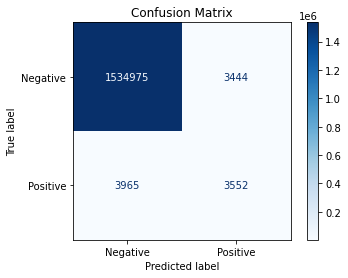

In [12]:
final_f1 = f1_score(y_test, y_pred)
print('Final F1 score: {:.2f}'.format(final_f1))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format='.0f')
plt.title("Confusion Matrix")
plt.show()

# Submission

In [13]:
wafers_test_names = wafers_test['WaferName'].copy() # store wafers name, as they are not useful in the features creation process

In [14]:
# Initialization and creation of the necessary features
wafers_test['x_diff'] = wafers_test.groupby('WaferName')['DieX'].diff()
wafers_test['y_diff'] = wafers_test.groupby('WaferName')['DieY'].diff()
wafers_test.fillna(0, inplace=True)
wafers_test['faulty_feature'] = wafers_test['IsGoodDie'].map({0:1,1:0})
sizes = [3,5,7]
kernels = {size: create_kernels(size) for size in sizes}

kernel_3x3 = np.ones((3, 3))
kernel_3x3[1, 1] = 0

kernel_5x5 = np.ones((5, 5))
kernel_5x5[2, 2] = 0

kernel_7x7 = np.ones((7, 7))
kernel_7x7[3, 3] = 0

wafers_test['faulty_neighbours_3x3'] = 0
wafers_test['faulty_neighbours_5x5'] = 0
wafers_test['faulty_neighbours_7x7'] = 0
wafers_test['canny_feature'] = 0
wafers_test['bounding_circle_faulty'] = 0
wafers_test['aggresive_out_remv'] = 0
wafers_test['sobol_median_filter'] = 0
wafers_test['connected'] = 0
wafers_test['skeleton'] = 0
wafers_test['skeleton_conv'] = 0
wafers_test['hough_line'] = 0
wafers_test['median_circle_outliers'] = 0




for size in sizes:
    wafers_test[f'faulty_diag_neighbours_{size}x{size}'] = 0
    wafers_test[f'faulty_non_diag_neighbours_{size}x{size}'] = 0

for WaferName in tqdm(wafers_test['WaferName'].unique()):
    tmpdf = wafers_test[wafers_test['WaferName'] == WaferName]
    full_disc = tmpdf\
        .pivot_table(index='DieX', columns='DieY', values='faulty_feature', fill_value=0)\
        .values 
    disc_array = tmpdf\
        .pivot_table(index='DieX', columns='DieY', values='faulty_feature', fill_value=0)\
        .values
    disc_array = ndimage.median_filter(disc_array, size=2)

    convs_vec = {size: (get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernels[size][0], mode='same'),
                                   f'faulty_diag_neighbours_{size}x{size}'),
                        get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernels[size][1], mode='same'),
                                   f'faulty_non_diag_neighbours_{size}x{size}'))
             for size in sizes}
    

    conv_3x3 = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernel_3x3, mode='same'),
                                   'faulty_neighbours_3x3')
    conv_5x5 = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernel_5x5, mode='same'),
                                   'faulty_neighbours_5x5')
    conv_7x7 = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,convolve2d(disc_array, kernel_7x7, mode='same'),
                                   'faulty_neighbours_7x7')
    
    canny_edge_det = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,canny(disc_array,sigma=0.7,use_quantiles=True),
                                   'canny_feature').astype(int)
    
    faulty_circle = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,get_bounding_circle_pixels(disc_array,0.5),
                                   'bounding_circle_faulty')
    agg_outs = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,remove_outliers(pd.DataFrame(get_bounding_circle_pixels(disc_array,
                                                                         tolerance = 1,outlier= True)),n=2,method ='ECOD'),'aggresive_out_remv')

    sobol_med_filt = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,np.hypot(ndimage.sobel(ndimage.median_filter(disc_array, size=2), axis=0, mode='constant'),
                                    ndimage.sobel(ndimage.median_filter(disc_array, size=2), axis=1, mode='constant'))\
                                    .astype(np.int8),
                                   'sobol_median_filter')
    connected = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,detect_curves_connected_components(disc_array),
                                   'connected')
    skeleton = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,detect_curves_skeletonization(disc_array),
                                   'skeleton')
    skeleton_conv = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,detect_curves_skeletonization_conv(full_disc),
                                   'skeleton_conv')

    med_circ_filt = ndimage.median_filter( get_bounding_circle_pixels(full_disc,tolerance = 1,outlier= True), size=2)
    med_circ = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,med_circ_filt,
                                   'median_circle_outliers')
    hue = get_vectorized_info(tmpdf[['WaferName','DieX', 'DieY']]
                                   ,apply_Hough_Transform(med_circ_filt),
                                   'hough_line')
       
    wafers_test.loc[conv_3x3.index, 'faulty_neighbours_3x3'] = conv_3x3
    wafers_test.loc[conv_5x5.index, 'faulty_neighbours_5x5'] = conv_5x5
    wafers_test.loc[conv_7x7.index, 'faulty_neighbours_7x7'] = conv_7x7
    wafers_test.loc[canny_edge_det.index, 'canny_feature'] = canny_edge_det
    wafers_test.loc[faulty_circle.index, 'bounding_circle_faulty'] = faulty_circle
    wafers_test.loc[agg_outs.index, 'aggresive_out_remv'] = agg_outs
    wafers_test.loc[sobol_med_filt.index, 'sobol_median_filter'] = sobol_med_filt
    wafers_test.loc[connected.index, 'connected'] = connected
    wafers_test.loc[skeleton.index, 'skeleton'] = skeleton
    wafers_test.loc[skeleton_conv.index, 'skeleton_conv'] = skeleton_conv
    wafers_test.loc[hue.index, 'hough_line'] = hue
    wafers_test.loc[med_circ.index, 'median_circle_outliers'] = med_circ

    for size in sizes:
        wafers_test.loc[convs_vec[size][0].index, f'faulty_diag_neighbours_{size}x{size}'] = convs_vec[size][0]
        wafers_test.loc[convs_vec[size][1].index, f'faulty_non_diag_neighbours_{size}x{size}'] = convs_vec[size][1]


  0%|          | 0/377 [00:00<?, ?it/s]

In [15]:
wtest = wafers_test[selected_features]

In [16]:
predictions_sub = []
for model in tqdm(models):
    pred = model.predict(wtest)
    predictions_sub.append(pred)

final_predictions = np.mean(predictions_sub, axis=0)
y_pred = np.round(final_predictions)
wtest['IsScratchDie'] = y_pred
wtest['WaferName'] = wafers_test_names

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-16-c8e48f0e2e4c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtest['IsScratchDie'] = y_pred
<ipython-input-16-c8e48f0e2e4c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtest['WaferName'] = wafers_test_names


In [17]:
df_wafers_test['IsScratchDie'] = 0

Recall that i already excluded the wafers with the yield factor lower than the decided threshold, hence their prediction will be 0.

In [18]:
finaldf = df_wafers_test.merge(
    wtest[df_wafers_test.columns],
    on = ['WaferName', 'DieX', 'DieY', 'IsGoodDie'],
    how='left').\
    drop('IsScratchDie_x',axis=1).\
    rename(columns = {'IsScratchDie_y':'IsScratchDie'}).\
    fillna(0)

In [20]:
finaldf.to_csv('df_wafers_test_with_preds.csv',index=False)

# Additional thoughts

I had an enjoyable experience exploring the work conducted by the team at NI! Despite being challenging, it was a great opportunity to work on a fascinating domain. The task was especially difficult due to the highly unbalanced nature of the training data, which made scaling and performance challenging.

The feature engineering process required careful attention to detail, as each new feature had to be really carefully considered due to high running time. Although some features that i guess would perform well were difficult to scale, such as Normalized graph cut segmentation, I decided not to create them due to the time it would take.

I made a mistake by choosing Hough transform as a feature because it was not helpful. Instead, I should have created a linear or polynomial regression for each wafer on the faulty dies after removing noise and boundaries. If I had done that and tuned it correctly, it might have improved the results.

I also naively enough tried to perform data augmentation in order to restore some balanace to the data. i followed the same heuristic that's common in images with NN and tried rotating, shifting/moving , scaling and flipping the scratched pixels. i was wrong as it only created scratches that are not true. it only feeded the model with ambiguity.  

While SVM with kernel trick is known to effectively detect and separate geometric shapes on higher dimensions, it was not scalable on the large dataset. I decided to use LightGBM instead, which scales well and is easy to tune. Through parameter tuning, I was able to achieve a 9% improvement in F1 score, which was nice in my opinion.

**Gil Zeevi**